# Fs-Peptide Spatio-temporal Decorrelation

# Identifying putative conformational substates by performing Robust Independent Component Analysis through Time-Lagged cumulant functions 

In [1]:
import pyemma
import os
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import MDAnalysis as mdanal

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.style.use('ggplot');

## Select Coordinates of Interest

The function below is a generic driver for obtaining coordinates of interest. The line with Ca specifies the coordinates selected, and is based on MDAnalysis selection syntax (http://pythonhosted.org/MDAnalysis/documentation_pages/selection.html). You can use a variety of atom selections that can be returned as a numpy array.





In [3]:
indir = '/Users/fxp/FsPeptide/analysis/dihedrals/trajs/'
topfile =  indir+'fs-peptide.pdb'
traj_list = []
for filename in os.listdir(indir):
    if filename.endswith('.xtc'):
        traj_list.append(os.path.join(indir,filename))

In [4]:
feat = coor.featurizer(topfile)
feat.add_backbone_torsions(cossin=True)
feat.add_chi1_torsions(cossin=True)

/Users/fxp/anaconda2/lib/python2.7/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [5]:
feat.dimension()

90

In [6]:
inp = coor.source(traj_list, feat)
print 'number of trajectories = ',inp.number_of_trajectories()
print 'trajectory length = ',inp.trajectory_length(0)
print 'trajectory time step = ',500.0 / (inp.trajectory_length(0)),'ns'
print 'number of dimension = ',inp.dimension()

number of trajectories =  28
trajectory length =  10000
trajectory time step =  0.05 ns
number of dimension =  90


In [7]:
pp = inp.get_output()
pp = np.asarray(pp);

In [8]:
pp = pp.reshape((pp.shape[0]*pp.shape[1], pp.shape[2]));
print pp.shape

(280000, 90)


## Spatial Decorrelation of Order 2 (SD2) 

Parameters:
               
               data – a 3n x T data matrix (number 3 is due to the x,y,z coordinates for each atom). Maybe a numpy   
               array or a matrix where,
               
               n: size of the protein 
               
               T: number of snapshots of MD trajectory
               
               m – dimensionality of the subspace we are interested in; Default value is None, in which case m = n
               verbose – print information on progress. Default is true.

Returns:

               A 3n x m matrix U (NumPy matrix type), such that Y = U * data is a 2nd order spatially whitened                        
               coordinates extracted from the 3n x T data matrix. If m is omitted, U is a square 3n x 3n matrix.
               
               Ds: has eigen values sorted by increasing variance
               
               PCs: holds the index for m most significant principal components by decreasing variance S = Ds[PCs] 
    
               S – Eigen values of the ‘data’ covariance matrix
      
               B – Eigen vectors of the ‘data’ covariance matrix. The eigen vectors are orthogonal.  



In [9]:
import SD2
(Y, S, B, U) = SD2.SD2(pp, m=90);

2nd order Spatial Decorrelation -> Looking for 90 sources
2nd order Spatial Decorrelation -> Removing the mean value
2nd order Spatial Decorrelation -> Whitening the data


## Temporal Decorrelation of Order 2 (TD2) 

Parameters:
    
        Y -- an mxT spatially whitened matrix (m dimensionality of subspace, T snapshots). May be a numpy 
             
             array or a matrix where,
             
        m -- dimensionality of the subspace we are interested in. Defaults to None, in
                which case m=n.
        T -- number of snapshots of MD trajectory
        
        U -- whitening matrix obtained after doing the PCA analysis on m components
                of real data
        
        lag -- lag time in the form of an integer denoting the time steps
        
        verbose -- print info on progress. Default is True.
    
Returns:

      	V -- An n x m matrix V (NumPy matrix type) is a separating matrix such that V = Btd2 x U 
        (U is obtained from SD2 of data matrix and Btd2 is obtained from time-delayed covariance of matrix Y)   
      
        Z -- Z = B2td2 * Y is spatially whitened and temporally decorrelated (2nd order) source extracted from 
        the m x T spatially whitened matrix Y.        

        Dstd2: has eigen values sorted by increasing variance

        PCstd2: holds the index for m most significant principal components by decreasing variance
        R = Dstd2[PCstd2] 

        R – Eigen values of the time-delayed covariance matrix of Y
  
        Btd2 – Eigen vectors of the time-delayed covariance matrix of Y
  



In [10]:
import TD2
#import TD2
(Z, R, Btd2, V) = TD2.TD2(Y, m=90, U=U, lag=100)

2nd order Temporal Decorrelation -> Looking for 90 sources
2nd order Temporal Decorrelation -> Removing the mean value
2nd order Temporal Decorrelation -> Whitening the data


## Temporal Decorrelation of Order 4 (TD4) 

Parameters:
    
        Z -- an mxT spatially uncorrelated of order 2 and temporally uncorrelated 
        of order 2 matrix (m subspaces, T samples). May be a  numpyarray or matrix where                  
                m: number of subspaces we are interested in.
                T: Number of snapshots of MD trajectory
        
        V -- separating matrix obtained after doing the PCA analysis on m components
              of real data followed temporal decorrelation of the spatially whitened 
              data
        
        lag -- lag time in the form of an integer denoting the time steps
        
        verbose -- print info on progress. Default is True.
    
Returns:
    
        W -- separating matrix    





In [11]:
import TD4

W = TD4.TD4(Z[0:10,:], m=10, V=V[0:10,:], lag=100)

4th order Temporal Decorrelation -> Estimating cumulant matrices
TD4 -> Contrast optimization by joint diagonalization
TD4 -> Sweep #  0 completed in 45 rotations
TD4 -> Sweep #  1 completed in 45 rotations
TD4 -> Sweep #  2 completed in 45 rotations
TD4 -> Sweep #  3 completed in 45 rotations
TD4 -> Sweep #  4 completed in 45 rotations
TD4 -> Sweep #  5 completed in 45 rotations
TD4 -> Sweep #  6 completed in 45 rotations
TD4 -> Sweep #  7 completed in 39 rotations
TD4 -> Sweep #  8 completed in 20 rotations
TD4 -> Sweep #  9 completed in 4 rotations
TD4 -> Sweep # 10 completed in 0 rotations
TD4 -> Total of 378 Givens rotations
TD4 -> Sorting the components
TD4 -> Fixing the signs
(10, 90)


In [12]:
ZPrj = W.dot(pp.T);

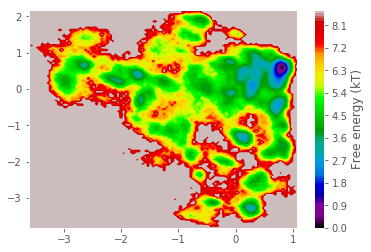

In [13]:
mplt.plot_free_energy(np.asarray(Z)[0,:], np.asarray(Z)[1,:] );

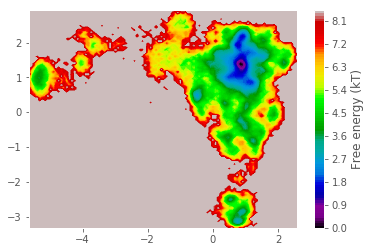

In [14]:
mplt.plot_free_energy(np.asarray(ZPrj)[0,:], np.asarray(ZPrj)[1,:] );

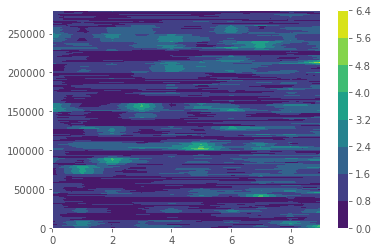

In [15]:
Y_TD2 = np.asarray(Z.T);
xx = plt.contourf(np.abs(Y_TD2[:,0:10]));
plt.colorbar();

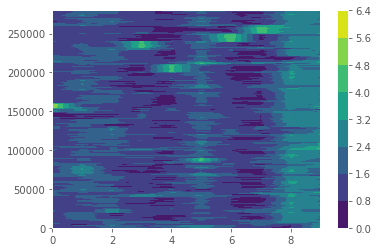

In [16]:
Y_TD4 = np.asarray(ZPrj.T);
xx = plt.contourf(np.abs(Y_TD4[:,0:10]));
plt.colorbar();

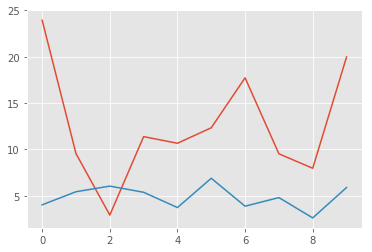

In [17]:
import scipy.stats
kTD4 = scipy.stats.kurtosis(Y_TD4, axis=0, fisher=False);
kTD2 = scipy.stats.kurtosis(Y_TD2[:,0:10], axis=0, fisher=False);
plt.plot(kTD4);
plt.plot(kTD2);
plt.show();

In [18]:
iTD4 = np.argsort(kTD4); iTD2 = np.argsort(kTD2); 
print iTD4, iTD2;

[2 8 7 1 4 3 5 6 9 0] [8 4 6 0 7 3 1 9 2 5]


In [19]:
Y_TD2 = Y_TD2[:, 0:10]; Y_TD2 = Y_TD2[:, iTD2]; print Y_TD2.shape;
Y_TD4 = Y_TD4[:, iTD4]; print Y_TD4.shape;

(280000, 10)
(280000, 10)


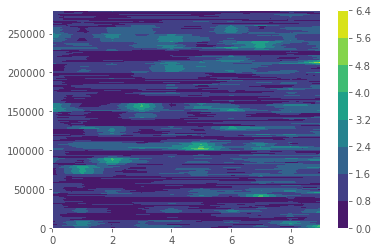

In [20]:
Y_TD2 = np.asarray(Z.T);
xx = plt.contourf(np.abs(Y_TD2[:,0:10]));
plt.colorbar();

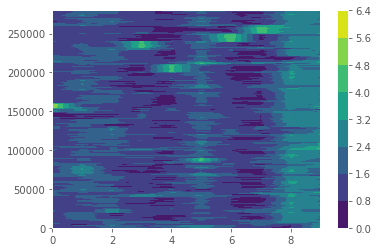

In [21]:
Y_TD4 = np.asarray(ZPrj.T);
xx = plt.contourf(np.abs(Y_TD4[:,0:10]));
plt.colorbar();

In [22]:
n_clusters = 250;     # number of k-means clusters
clusters_TD2 = coor.cluster_kmeans(Y_TD2[:,0:5], k=n_clusters, max_iter=50);

18-05-17 12:07:37 pyemma.coordinates.clustering.kmeans.KmeansClustering[1] INFO     Cluster centers converged after 12 steps.


In [23]:
clusters_TD4 = coor.cluster_kmeans(Y_TD4, k=n_clusters, max_iter=50);

18-05-17 12:08:11 pyemma.coordinates.clustering.kmeans.KmeansClustering[2] INFO     Cluster centers converged after 12 steps.


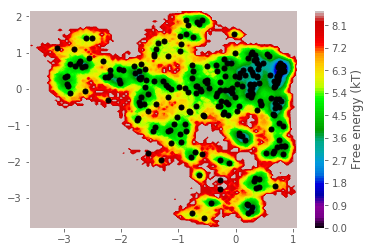

In [24]:
mplt.plot_free_energy(np.asarray(Y_TD2)[:,0], np.asarray(Y_TD2)[:,1]);
cc_x_TD2 = clusters_TD2.clustercenters[:,0]
cc_y_TD2 = clusters_TD2.clustercenters[:,1]
plot(cc_x_TD2,cc_y_TD2, linewidth=0, marker='o', markersize=5, color='black')

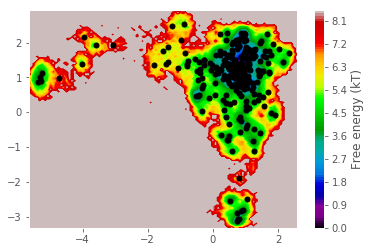

In [25]:
mplt.plot_free_energy(Y_TD4[:,0], Y_TD4[:,1]);
cc_x_TD4 = clusters_TD4.clustercenters[:,0];
cc_y_TD4 = clusters_TD4.clustercenters[:,1];
plot(cc_x_TD4, cc_y_TD4, linewidth=0, marker='o', markersize=5, color='black');

(8, 10)


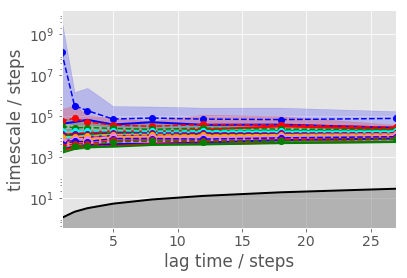

In [26]:
dtrajs_TD4 = clusters_TD4.dtrajs;
its = msm.timescales_msm(dtrajs_TD4, lags=40, nits=10, errors='bayes');
xx = its.timescales; print xx.shape;
matplotlib.rcParams.update({'font.size': 14})
mplt.plot_implied_timescales(its, ylog=True, units='steps', linewidth=2)

In [27]:
msm_lag = 15
M = msm.estimate_markov_model(dtrajs_TD4, msm_lag)
print 'fraction of states used = ', M.active_state_fraction
print 'fraction of counts used = ', M.active_count_fraction

fraction of states used =  0.992
fraction of counts used =  0.989242857143


In [28]:
M = msm.bayesian_markov_model(dtrajs_TD4, msm_lag)

In [29]:
hmm = M.coarse_grain(3)

In [30]:
hmm.stationary_distribution

array([ 0.09566677,  0.06287941,  0.84145383])

In [31]:
hmm.transition_matrix

array([[  9.96758004e-01,   1.37959729e-64,   3.24199631e-03],
       [  2.09896404e-64,   9.94284550e-01,   5.71544976e-03],
       [  3.68589809e-04,   4.27099000e-04,   9.99204311e-01]])

(<matplotlib.figure.Figure at 0x146efb550>, array([[ 1.        ,  0.95777398],
        [ 0.        ,  0.        ],
        [ 0.49999999,  0.47888698]]))

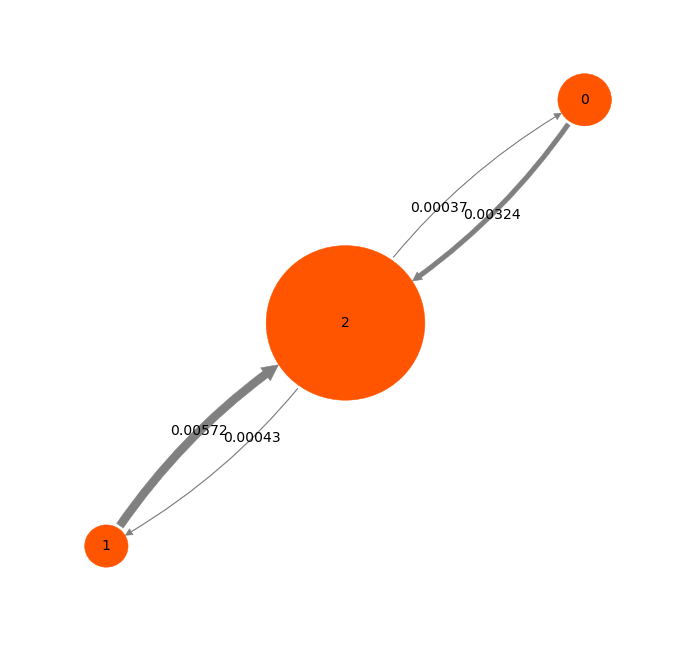

In [32]:
mplt.plot_markov_model(hmm, arrow_label_format='%.5f')

(8, 10)


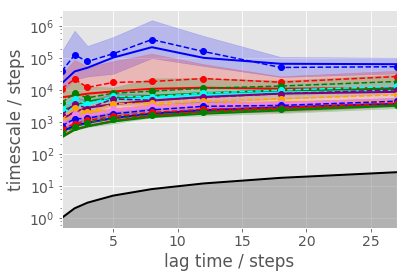

In [33]:
dtrajs_TD2 = clusters_TD2.dtrajs;
its = msm.timescales_msm(dtrajs_TD2, lags=40, nits=10, errors='bayes');
xx = its.timescales; print xx.shape;
matplotlib.rcParams.update({'font.size': 14})
mplt.plot_implied_timescales(its, ylog=True, units='steps', linewidth=2)

In [34]:
msm_lag = 20
M = msm.estimate_markov_model(dtrajs_TD2, msm_lag)
print 'fraction of states used = ', M.active_state_fraction
print 'fraction of counts used = ', M.active_count_fraction

fraction of states used =  1.0
fraction of counts used =  1.0


In [35]:
M = msm.bayesian_markov_model(dtrajs_TD2, msm_lag)

In [36]:
hmm = M.coarse_grain(3)

18-05-17 12:13:46 pyemma.msm.estimators.bayesian_msm.BayesianMSM[3] WARNING  Requested coarse-grained model with 3 metastable states at lag=20.The ratio of relaxation timescales between 3 and 4 states is only 1.10180807652 while we recommend at least 1.5.  It is possible that the resulting HMM is inaccurate. Handle with caution.


In [37]:
hmm.stationary_distribution

array([ 0.10268623,  0.85592093,  0.04139285])

In [38]:
hmm.transition_matrix

array([[  9.95080538e-01,   4.57162088e-03,   3.47841137e-04],
       [  5.48464805e-04,   9.99325369e-01,   1.26166070e-04],
       [  8.62914684e-04,   2.60886097e-03,   9.96528224e-01]])

(<matplotlib.figure.Figure at 0x1119c2e10>, array([[ 0.4487549 ,  1.        ],
        [ 0.40533229,  0.41948413],
        [ 0.        ,  0.        ]]))

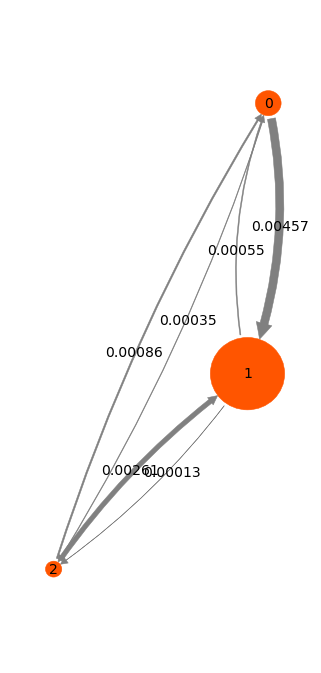

In [39]:
mplt.plot_markov_model(hmm, arrow_label_format='%.5f')